## Machine Learning for Public Policy - Problem Set 4

In [135]:
# import and package setup
import pandas as pd
from pandas.errors import SettingWithCopyWarning
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import warnings
import math
import textwrap
import sklearn
import time
import os
import re
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, LassoLarsIC, Ridge 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score, cross_validate, LeaveOneOut
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, roc_curve, roc_auc_score, RocCurveDisplay, make_scorer, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
import mlxtend
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

warnings.filterwarnings("ignore")

# data import 
college_df = pd.read_csv('Data-College.csv')
oj_df = pd.read_csv('Data-OJ.csv')

In [136]:
# quick data cleanup

# looking at the dataset, the college name column is mislabeled so I'll fix it here
college_df = college_df.rename(columns={'Unnamed: 0': 'school_name'})

# also fixing the column names to have a standard form
def to_snake_case(name):
    name = re.sub(r'[^\w\s]', '', name).lower() 
    name = re.sub(r'\s+', '_', name).replace('-', '_')
    return name

college_df.columns = college_df.columns.map(to_snake_case)

In [137]:
# 1(a) -- train test split the data with the stated random seed
rs = 37

# conversion of non-numerical data to binary for prediction
college_df['private'] = np.where(college_df['private'] == 'Yes', 1, 0)

# extracting our target X, Y for model building
predictor_cols = [col for col in college_df.columns if col not in ['school_name', 'apps']]

# train-test split
train_college_df, test_college_df = train_test_split(college_df, test_size= 0.5, random_state= rs)

x_train_college_df = train_college_df[predictor_cols]
y_train_college_df = train_college_df['apps']

x_test_college_df = test_college_df[predictor_cols]
y_test_college_df = test_college_df['apps']

# Scaling the predictors
scaler = StandardScaler()

# Fit and transform the x data
x_train_college_scaled = scaler.fit_transform(x_train_college_df)
x_train_college_scaled_df = pd.DataFrame(x_train_college_scaled, columns=predictor_cols, index=x_train_college_df.index)

x_test_college_scaled = scaler.transform(x_test_college_df)
x_test_college_scaled_df = pd.DataFrame(x_test_college_scaled, columns=predictor_cols, index=x_test_college_df.index)


In [138]:
# 1(b) -- standard linear model fitting
ols = LinearRegression().fit(x_train_college_scaled_df, y_train_college_df)

y_pred_train_college_df = ols.predict(x_train_college_scaled_df)
mse_train_college_ols = mean_squared_error(y_train_college_df, y_pred_train_college_df)
y_pred_test_college_df = ols.predict(x_test_college_scaled_df)
mse_test_college_ols = mean_squared_error(y_test_college_df, y_pred_test_college_df)

# showing our results
print(f"Train MSE for OLS:", round(mse_train_college_ols, 3))
print(f"Test MSE for OLS:", round(mse_test_college_ols, 3))

Train MSE for OLS: 1150245.725
Test MSE for OLS: 1222954.038


Optimal number of principal components (m) for PCR: 16
Test MSE for PCR:  2711494.125915838


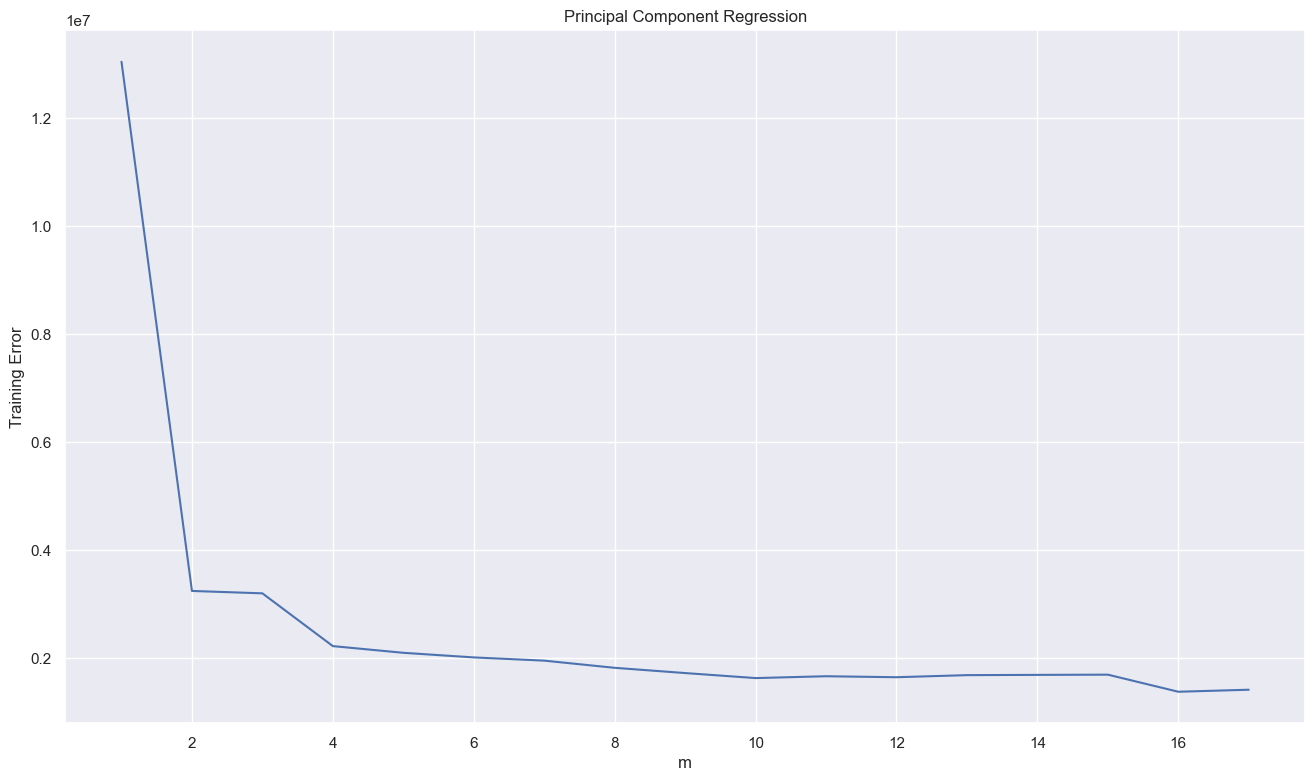

In [139]:
# 1(c) -- principal components regression
train_error_pcr = {}

# Perform PCR for all possible number of principal components
for m in range(1, len(x_train_college_scaled_df.columns)+1):
    pcr = make_pipeline(StandardScaler(),  # Transformer 1 - scale the data
                        PCA(n_components=m),  # Transformer 2 - PCA to find M number of principal components
                        LinearRegression()  # Estimator
                       ).fit(x_train_college_scaled_df, y_train_college_df)

    train_error_pcr[m] = np.mean(-1*cross_val_score(pcr,
                                                    x_train_college_scaled_df, y_train_college_df,
                                                    cv=KFold(n_splits= 10,
                                                             random_state= 1,
                                                             shuffle=True), 
                                                    scoring='neg_mean_squared_error'))

# Finding and saving the optimal 'm'
optimal_m_pcr = min(train_error_pcr, key=train_error_pcr.get)
print(f"Optimal number of principal components (m) for PCR: {optimal_m_pcr}")

# checking the pcr quality
pcr = make_pipeline(PCA(n_components=10), LinearRegression())

# Fit the PCR pipeline on the training data
pcr.fit(x_train_college_scaled_df, y_train_college_df)

# Assess the fit using the test data
y_predict_pcr_college_df = pcr.predict(x_test_college_scaled_df)

# Obtain the test error
test_mse_pcr = mean_squared_error(y_test_college_df, y_predict_pcr_college_df)
print("Test MSE for PCR: ", test_mse_pcr)


# Graph of train_error to help with interpretation
fig, ax = plt.subplots(figsize=(16, 9), facecolor='white')
ax.plot(list(train_error_pcr.keys()), list(train_error_pcr.values()), 'b-')
ax.set_xlabel('m')
ax.set_ylabel('Training Error')
ax.set_title('Principal Component Regression')

plt.show()

# 1(c) -- interpretation

Based off of the results from the mathematical analysis, __we would assume that the optimal 'm' is 16. However, if we go with the elbow technique, we can clearly see that the optimal 'm' is 4.__ This value of m at the elbow is based on the last spot where there is a significant drop in accuracy, and since we know that continually increasing the number of principal components could lead to overfitting, we can essentially decide that it's not worth it for us to add in more if there are diminishing returns on error reduction.

Optimal number of principal components (m) for PLS: 17
Test MSE for PLS: 2587430.59


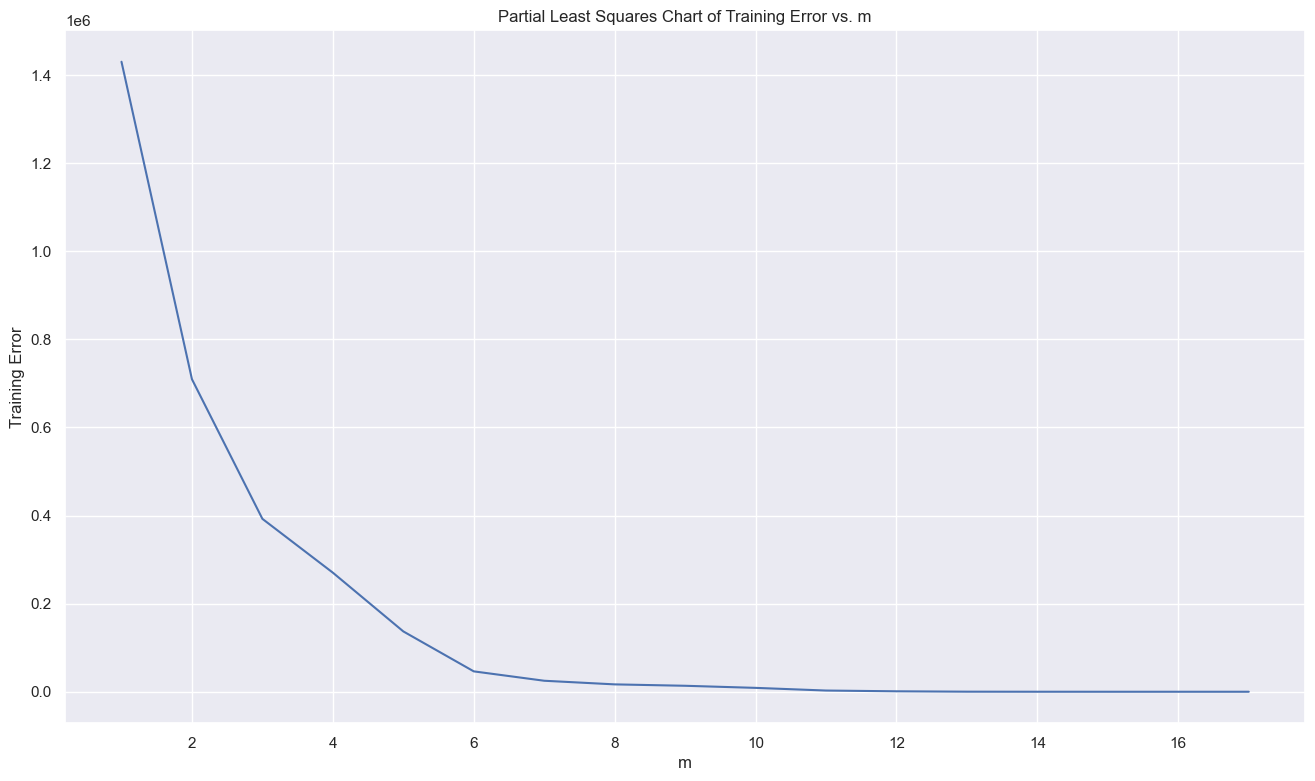

In [140]:
# 1(d) -- fitting the data to a Partial Least Squares approach

# Storing the MSEs
train_error_pls = {}

# Perform PLS for all possible number of principal components
for m in range(1, len(x_train_college_scaled_df.columns)+1):
    pls = PLSRegression(n_components=m,
                        scale=False).fit(x_train_college_scaled_df, y_train_college_df)
    
    train_error_pls[m] = np.mean(-1*cross_val_score(pls, 
                                                    x_train_college_scaled_df, y_pred_train_college_df, 
                                                    cv=KFold(n_splits=10,
                                                             random_state=1,
                                                             shuffle=True), 
                                                    scoring='neg_mean_squared_error'))

# Finding and saving the optimal 'm'
optimal_m_pls = min(train_error_pls, key= train_error_pls.get)
print(f"Optimal number of principal components (m) for PLS: {optimal_m_pls}")
   
# finding the MSE for PLS
pls = PLSRegression(n_components=3,
                    scale=True).fit(x_train_college_scaled_df, y_train_college_df)

y_predict_pls = pls.predict(x_test_college_scaled_df)
test_mse_pls = mean_squared_error(y_test_college_df, y_predict_pls)
print(f"Test MSE for PLS: {test_mse_pls:.2f}")


# Visualize the results
fig, ax = plt.subplots(figsize=(16, 9), facecolor='white')
ax.plot(list(train_error_pls.keys()), list(train_error_pls.values()))
ax.set_xlabel('m')
ax.set_ylabel('Training Error')
ax.set_title('Partial Least Squares Chart of Training Error vs. m')

plt.show()

# 1(d) -- interpretation

Looking at the output chart above, we can see that __the elbow method here would recommend that we select an 'm' of 6__. This value is somewhat different from what we found in part 1(c) with the PCR approach, but still fairly close.

Similarly to the previous problem, the 'ideal m' according to the mathematical approach is the maximum possible number of variables, however as mentioned in the previous interpretation section, we don't find this value to be particularly compelling since the inclusion of all variables would likely introduce a significant amount of overfitting and render the model not particularly useful.

# 1 (e) -- reactions to all results for part 1

Below are the critical results of our three different approaches (normal OLS, PCR, and PLS):

> - Test MSE for OLS: 1222954.038
> - Test MSE for PCR:  2711494.125915838
> - Test MSE for PLS: 2587430.59

Looking at our results, we can see massive values for our MSE regardless of the approach we use, so we should proceed with caution before even addressing the heirarchy of our results. We can see from the results above that __the OLS approach resulted in the lowest MSE, then PLS, then PCR__. Between PCR and PLS there is not much of a difference, however both of them are more than double the MSE of the traditional OLS approach. This may indicate that we need to consider using a wider dataset or perhaps implementing some degree of bootstrapping to see if there is some underlying noise that these PCR and PLS approaches are inadvertantly amplifying.


If we want to consider these results in the context of the dataset, we could look towards converting our test MSE to RMSE. This change would take it from the average of the squared errors to the average error, allowing us to consider these values in the context of the data. __So, in our case, the OLS model's error is an average of mis-predicting by 1,105 applications, and we can comfortably say that this not a reasonable model to use to predict applications recieveed__. If you dive into the data, that value is quite big considering that the mean number of applications in the column is ~3,000!

# 2(a) -- predictor space tree creation

![Data Tree Diagram](2a_tree_diagram.jpeg)


# 2(b) -- trees and drawing predictor spaces

![Predictor Space Diagram](2b_box_diagram.jpeg)

In [141]:
# 3(a) -- train/test split for the OJ data (with a new rs!)
rs2 = 3

# checking for non-numerical data and converting to binary for prediction
oj_df['Store7'] = np.where(oj_df['Store7'] == 'Yes', 1, 0)

# extracting our target X, Y for model building
predictor_cols_oj = [col for col in oj_df.columns if col != 'Purchase']

# train-test split
train_oj_df, test_oj_df = train_test_split(oj_df, test_size= 0.3, random_state= rs2)

x_train_oj_df = train_oj_df[predictor_cols_oj]
y_train_oj_df = train_oj_df['Purchase']

x_test_oj_df = test_oj_df[predictor_cols_oj]
y_test_oj_df = test_oj_df['Purchase']

# Scaling the predictors -- not explicitly requested but a good practice to do!
scaler = StandardScaler()

# Fit and transform the x data
x_train_oj_scaled = scaler.fit_transform(x_train_oj_df)
x_train_oj_scaled_df = pd.DataFrame(x_train_oj_scaled, columns= predictor_cols_oj, index= x_train_oj_df.index)

x_test_oj_scaled = scaler.transform(x_test_oj_df)
x_test_oj_scaled_df = pd.DataFrame(x_test_oj_scaled, columns= predictor_cols_oj, index= x_test_oj_df.index)

In [142]:
# 3(b) -- fitting a full tree

# model fitting
full_model = DecisionTreeClassifier(
    random_state=12,
    criterion='gini')
full_model.fit(x_train_oj_scaled_df, y_train_oj_df)

# collecting accuracies and error rates

oj_training_accuracy = full_model.score(x_train_oj_scaled_df, y_train_oj_df)
oj_test_accuracy = full_model.score(x_test_oj_scaled_df, y_test_oj_df)

print(f'Training Error Rate: {1 - oj_training_accuracy}')
print(f'(Good to print for continuity) Test Error Rate: {1 - oj_test_accuracy}')


Training Error Rate: 0.006675567423230944
(Good to print for continuity) Test Error Rate: 0.2679127725856698


Full, Unpruned Tree


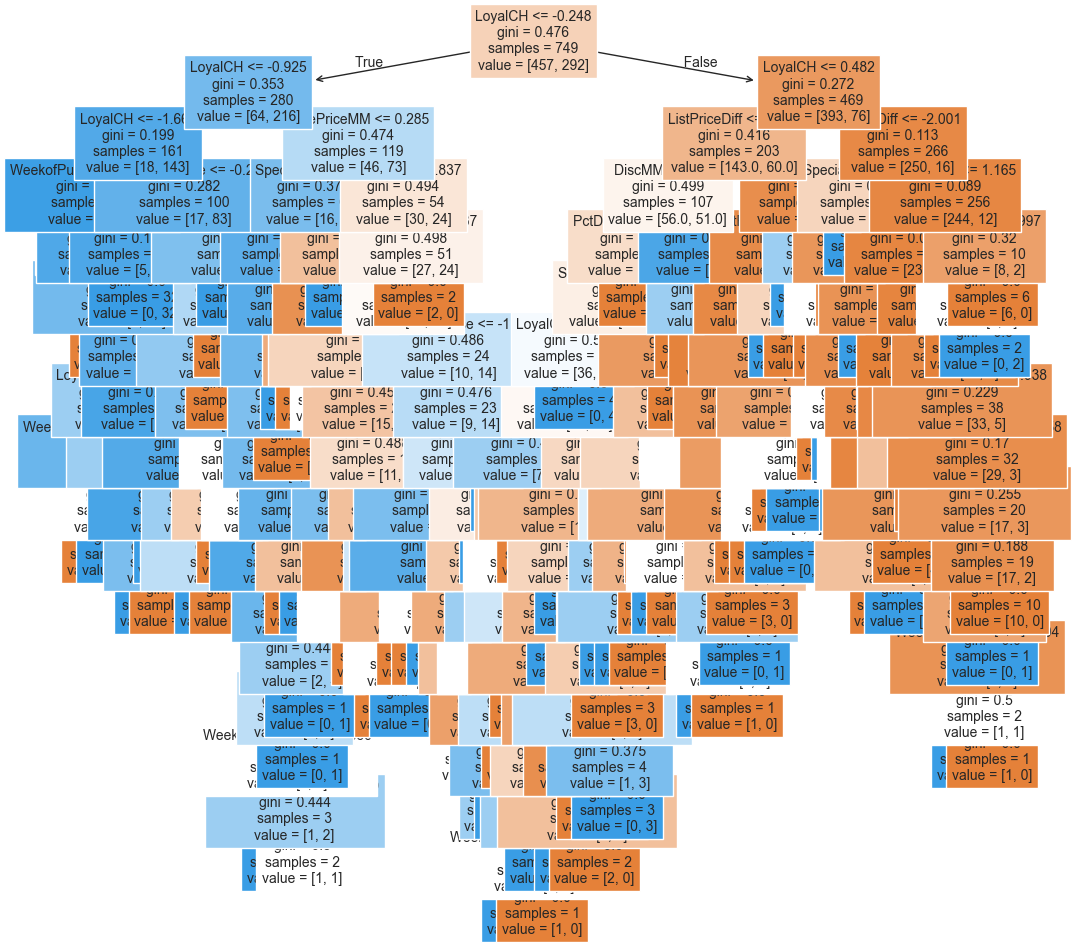

Number of terminal nodes for the full tree: 155
Limited Tree with a Max Depth of 3


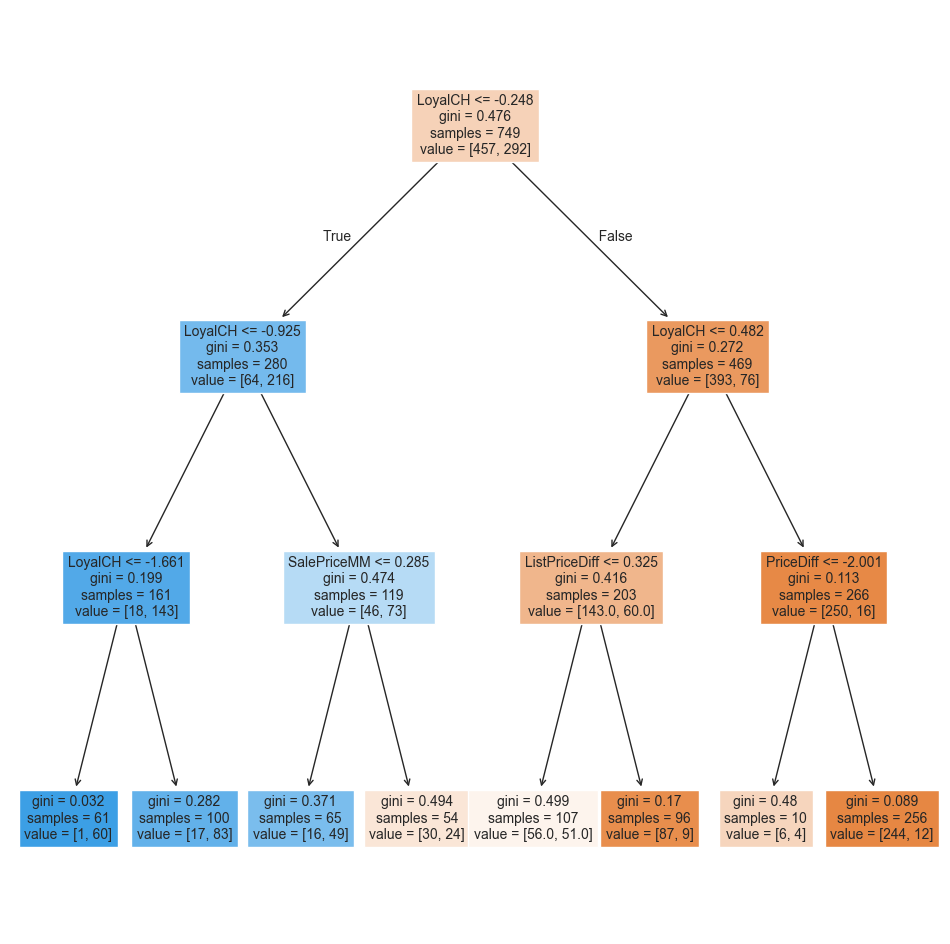

Number of terminal nodes for the Max 3 tree: 8
Max 3 - Training Accuracy: 0.8210947930574098
Max 3 - Test Accuracy: 0.8068535825545171


In [143]:
# 3(c) -- plotting the full, unpruned tree

# plotting the original, full tree
print("Full, Unpruned Tree")
plt.figure(figsize=(12,12), facecolor='white')
tree.plot_tree(full_model, fontsize=10, feature_names= x_train_oj_scaled_df.columns.tolist(), filled=True)
plt.show()

# Finding the number of terminal nodes for this unpruned model
num_terminal_nodes = full_model.tree_.n_leaves
print(f"Number of terminal nodes for the full tree: {num_terminal_nodes}")

print("Limited Tree with a Max Depth of 3")
# re-trying with a max depth of 3 since the model is massive!
max_depth_model = DecisionTreeClassifier(
    max_depth=3,
    random_state=1,
    criterion='gini').fit(x_train_oj_scaled_df, y_train_oj_df)

plt.figure(figsize=(12,12), facecolor='white')
tree.plot_tree(max_depth_model, fontsize=10, feature_names= x_train_oj_scaled_df.columns.tolist(), filled=True)
plt.show()

# Finding the number of terminal nodes for the pruned model
max3_num_terminal_nodes = max_depth_model.tree_.n_leaves
print(f"Number of terminal nodes for the Max 3 tree: {max3_num_terminal_nodes}")

print(f'Max 3 - Training Accuracy: {max_depth_model.score(x_train_oj_scaled_df, y_train_oj_df)}')
print(f'Max 3 - Test Accuracy: {max_depth_model.score(x_test_oj_scaled_df, y_test_oj_df)}')


# 3(c) -- interpretation 

As the prompt notes, the original, unpruned tree is indeed a mess! When checking the number of terminal nodes for the unpruned tree, we got 155, __however for the max 3 pruned tree, we found there to be 8 nodes__. That reduction and cleanup up gave us a much more interesting tree to work with!

Looking at the resulting max 3 pruned chart, we can see that certain variables were very useful in splitting up the population, with some like LoyalCH (presumably brand loyalty for orange juice?) being present in multiple spots on our tree. LoyalCH in fact represented the dominant variable for splitting, on the lefthand side of the tree we can see three different splits at different values there being the mathematically determined ideal tree branching. Other variables, such as SalePriceMM, ListPriceDiff, and PriceDiff were also useful, however none appeared as early in the tree as LoyalCH, so we can comfortably say that it is likely, given this chart, that this variable holds more power in influencing our results and determining the best 'classes' in this dataset. 

Test Error Rate: 0.2679127725856698


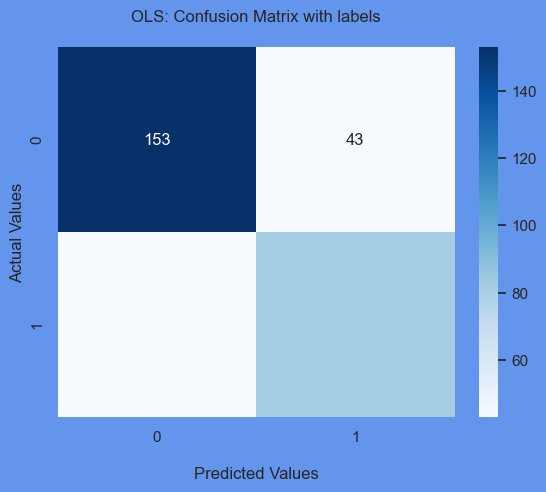

In [144]:
# 3(d) -- fitting the data to the full unpruned tree!

# checking the quality of the full tree for reference

y_hat_test = full_model.predict(x_test_oj_scaled_df)
cm = confusion_matrix(y_test_oj_df, y_hat_test)

sns.set(rc={'figure.facecolor': 'cornflowerblue'})
ax = sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues')
ax.set_title('OLS: Confusion Matrix with labels\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')
print("Test Error Rate:", 1-accuracy_score(y_test_oj_df, y_hat_test))

Optimal ccp_alpha: 0.01379269302194669
Lowest cross-validation error rate: 0.19222371364653257


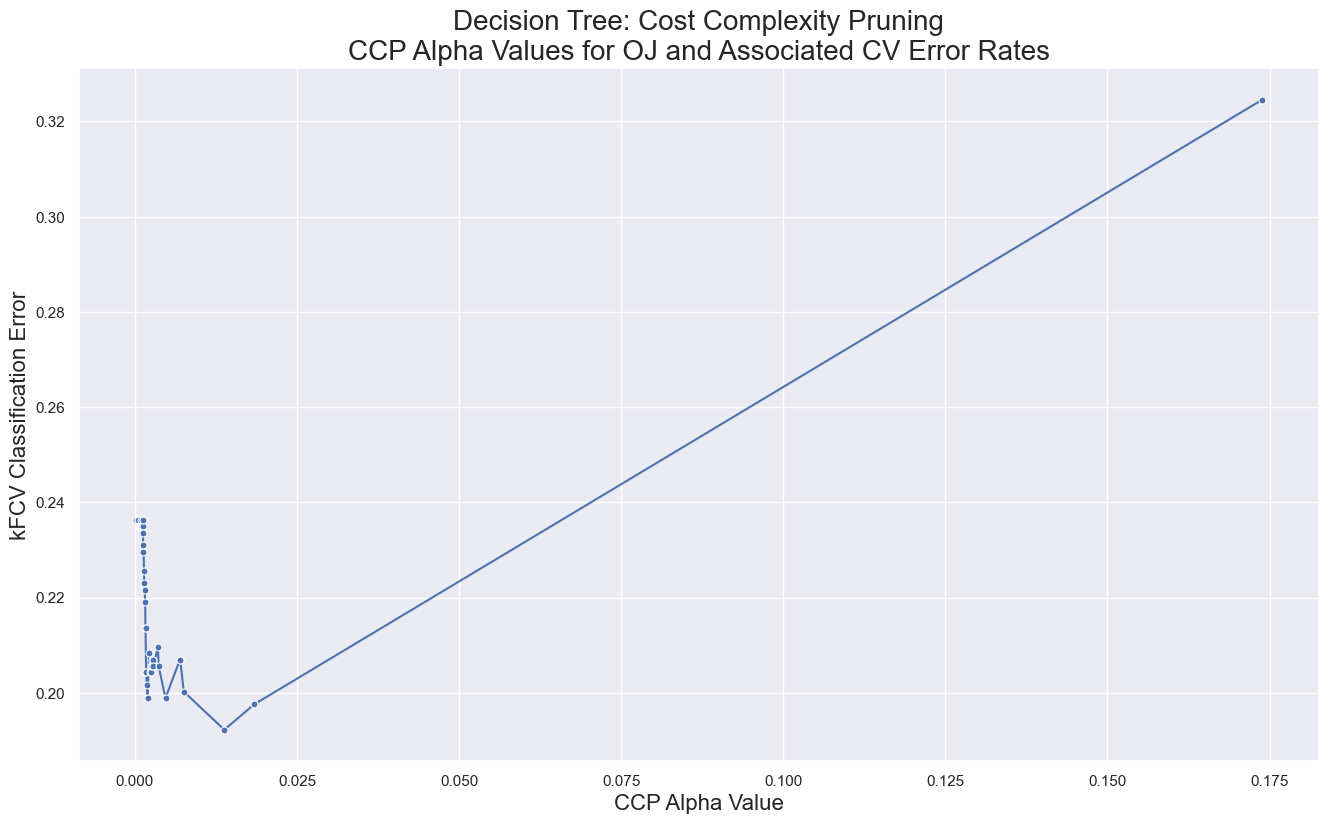

In [145]:
# 3(e) -- cost complexity pruning (with a new random state)
rs3 = 13

# cost complexity set up
path = full_model.cost_complexity_pruning_path(x_train_oj_scaled_df, y_train_oj_df)
ccp_alphas_oj = path.ccp_alphas
parameters = {'ccp_alpha': ccp_alphas_oj}

# Use GridSearchCV to iterate over the CCP alphas... 
kf = KFold(n_splits=5, random_state = rs3, shuffle=True)
cv_tree_oj = GridSearchCV(full_model, parameters, cv = kf, scoring='accuracy')
cv_tree_oj.fit(x_train_oj_scaled_df, y_train_oj_df)

# creating and saving our ccp results
cv_scores_oj = []
for mean_score in cv_tree_oj.cv_results_["mean_test_score"]:
    cv_scores_oj.append(1-mean_score)

# Find the alpha with the lowest error
min_error = min(cv_scores_oj)
optimal_alpha_index = cv_scores_oj.index(min_error)
optimal_alpha = ccp_alphas_oj[optimal_alpha_index]

print(f"Optimal ccp_alpha: {optimal_alpha}")
print(f"Lowest cross-validation error rate: {min_error}")

# Plot the error rate as a function of alpha
fig, ax = plt.subplots(figsize=(16,9), facecolor='white')
sns.lineplot(x= ccp_alphas_oj, y= cv_scores_oj, marker='o', markersize=5, ax=ax)
ax.set_ylabel("kFCV Classification Error", fontsize=16)
ax.set_xlabel("CCP Alpha Value", fontsize=16)
ax.set_title('Decision Tree: Cost Complexity Pruning'
             '\nCCP Alpha Values for OJ and Associated CV Error Rates',
             fontsize=20)
plt.show()

# 3(e) -- Interpretation

From our code results above, both visually inspecting the chart and checking by printing the min value, we can see that the value of alpha that corresponds to the lowest CV classification error rate occurs around an alpha of __0.014__. From our chart we can see this as being the dip right before a steady, massive increase in error rate, and this visual confirmation helps underscore the mathematical results, unlike problem 1(c) where the elbow method results contradicted the mathematical 'ideal' value. 


Tree size with lowest CV classification error rate: 4


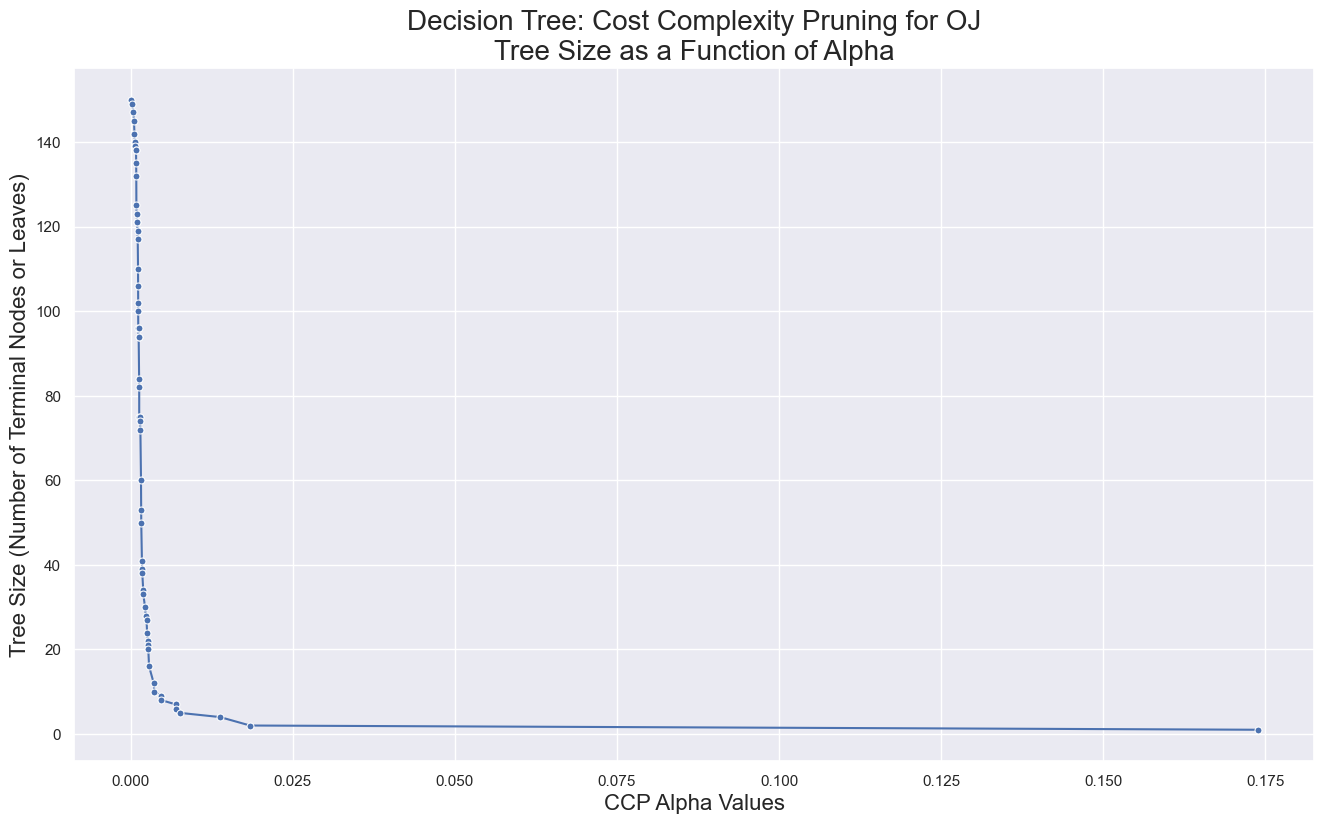

In [146]:
# 3(f) -- tree size and CV classification error rate plotting of the same data

# capturing tree size
tree_size_oj = []
for a in ccp_alphas_oj:
    clf_a = DecisionTreeClassifier(ccp_alpha=a, random_state= rs3, criterion='gini')
    clf_a.fit(x_train_oj_scaled_df, y_train_oj_df)
    tree_size_oj.append(clf_a.get_n_leaves())

# Find the tree size with the lowest cv error classification rate
optimal_tree_size = tree_size_oj[optimal_alpha_index]
print(f"Tree size with lowest CV classification error rate: {optimal_tree_size}")

# plotting the decision tree size vs. alpha relationship
fig, ax = plt.subplots(figsize=(16,9), facecolor='white')
sns.lineplot(x= ccp_alphas_oj, y= tree_size_oj, marker='o', markersize=5, ax=ax)
ax.set_ylabel("Tree Size (Number of Terminal Nodes or Leaves)", fontsize=16)
ax.set_xlabel("CCP Alpha Values", fontsize=16)
ax.set_title('Decision Tree: Cost Complexity Pruning for OJ'
             '\nTree Size as a Function of Alpha',
             fontsize=20)
plt.show()

# 3(f) -- interpretation of results

If we just looked at the chart, we wouldn't be able to easily tell the relationship between tree size and cv classification error rate, there is so much clustering towards the lefthand side of the chart! However, we can just ask VSCode to show us the related tree size when the alpha is at its optimal value, __so we can know that a tree size of 4 is ideal__.

Alpha, in the context of this classification analysis, is a penalty tool used to 'punish' overzealous complexity in a decision tree building context. Simply put, if we didn't have this limitation, the algorithim would always default to introducing an exhorbitant amount of complexity that would render the model a perfect fit to the training data set, but highly overfitted for the test data set and unlikely to be useful overall. Alpha introduces balance to the system by applying a counterweight penalty that increases as the number of branches increases in the decision tree.

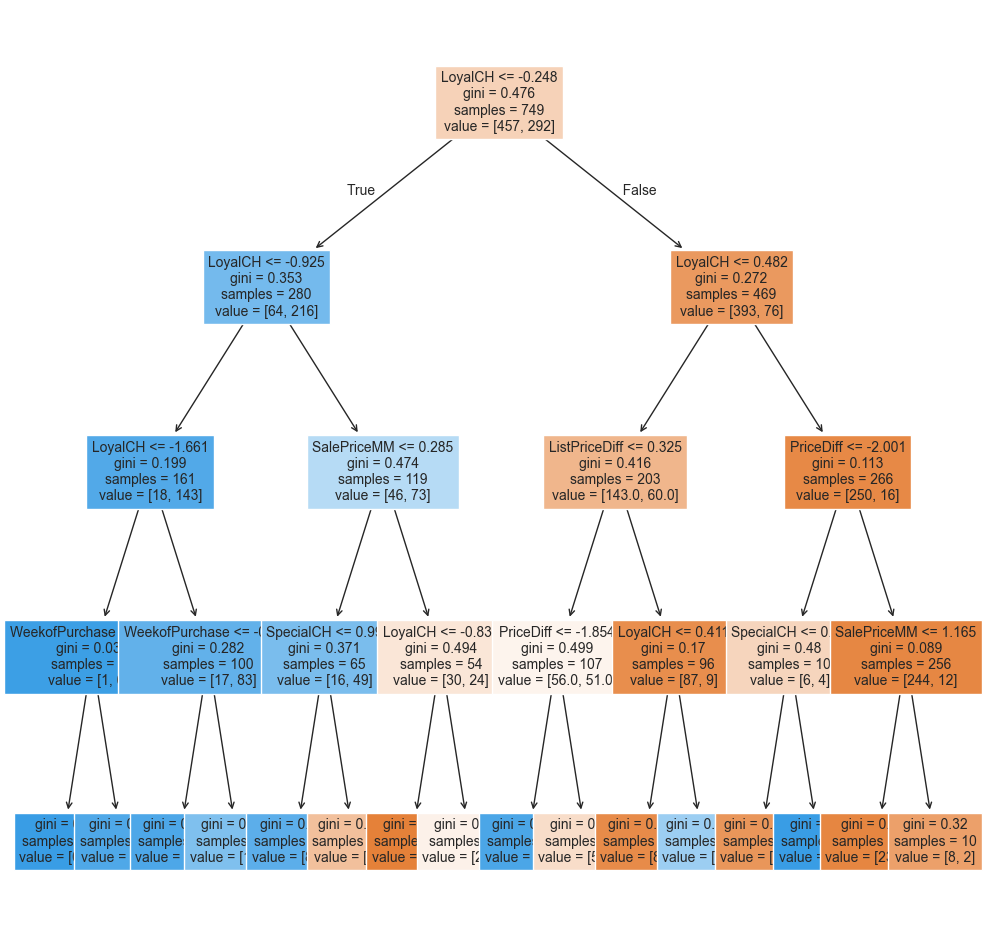

In [147]:
# 3(g) -- plotting the optimal pruned subtree

# re-assing our model
optimal_depth_model = DecisionTreeClassifier(
    max_depth= optimal_tree_size,
    random_state= rs3,
    criterion='gini').fit(x_train_oj_scaled_df, y_train_oj_df)

plt.figure(figsize=(12,12), facecolor='white')
tree.plot_tree(optimal_depth_model, fontsize=10, feature_names= x_train_oj_scaled_df.columns.tolist(), filled=True)
plt.show()

In [148]:
# 3(h) -- finding the training error rates for pruned vs. unpruned

# pruned test error rate
print(f'Pruned (4) Train Error: {1 - optimal_depth_model.score(x_train_oj_scaled_df, y_train_oj_df)}')

# unpruned test error rate
print(f'Unpruned Train Error: {1 - full_model.score(x_train_oj_scaled_df, y_train_oj_df)}')

Pruned (4) Train Error: 0.15487316421895858
Unpruned Train Error: 0.006675567423230944


# 3(h) -- interpretation

Looking at the training error rate results, we see that the unpruned tree has a remarkable low error rate! __The pruned tree has a higher train error rate__, though the value is not particularly high, so it still may be a valid model to use. Indeed the unpruned tree error rate is so low that we may be concerned about overfitting!

In [149]:
# 3(i) -- finding the test error rates for pruned vs. unpruned

# pruned test error rate
print(f'Pruned (4) Test Error: {1 - optimal_depth_model.score(x_test_oj_scaled_df, y_test_oj_df)}')

# unpruned test error rate
print(f'Unpruned Test Error: {1 - full_model.score(x_test_oj_scaled_df, y_test_oj_df)}')

Pruned (4) Test Error: 0.19937694704049846
Unpruned Test Error: 0.2679127725856698


# 3(i) -- interpretation

Now, we can see the reverse situation from what we saw in 3(h), __now the test error rate of the unpruned tree is much higher than the pruned tree__. This is a good way for us to validate the concern of overfitting from the previous, this large swing for the unpruned tree would indicate that the model is fit too tightly to the training set and does not apply as well to the test set. Expanding beyond the specific case, we can come to the understanding that using unpruned trees has the tendency to overfit to specific cases and may not be as effective when applied to the broader data sample or even to the general population.